In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# Config
DATA_DIR = Path("data")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "valid"
TEST_DIR = DATA_DIR / "test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
NUM_CLASSES_LIMIT = 10   
AUTOTUNE = tf.data.AUTOTUNE

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [2]:
def get_classes(directory, limit=None):
    classes = sorted([d.name for d in Path(directory).iterdir() if d.is_dir()])
    if limit:
        classes = classes[:limit]
    return classes

# 1. Get specific classes
classes = get_classes(TRAIN_DIR, NUM_CLASSES_LIMIT)
print(f"Using {len(classes)} Classes:")
for c in classes: print(" -", c)

# 2. Data Loader
def load_dataset(directory, class_names, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        class_names=class_names,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=shuffle
    )
    
    # FIX: Removed division by 255.0. We keep range [0, 255] for EfficientNet
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y),
                num_parallel_calls=AUTOTUNE)

    return ds.prefetch(AUTOTUNE)

train_ds = load_dataset(TRAIN_DIR, classes, shuffle=True)
val_ds   = load_dataset(VAL_DIR, classes, shuffle=False)

Using 10 Classes:
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Blueberry___healthy
 - Cherry_(including_sour)___Powdery_mildew
 - Cherry_(including_sour)___healthy
 - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 - Corn_(maize)___Common_rust_
 - Corn_(maize)___Northern_Leaf_Blight
Found 18553 files belonging to 10 classes.
Found 4638 files belonging to 10 classes.


In [3]:
# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
], name="augmentation")

# Base Model
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False # Start frozen

# Build Full Model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)

# This layer handles the specific scaling required by EfficientNetV2
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(classes), activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,249,818 (23.84 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [4]:
callbacks_list = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor='val_loss'),
    callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=callbacks_list
)

Epoch 1/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 324s 537ms/step - accuracy: 0.9137 - loss: 0.2540 - val_accuracy: 0.9644 - val_loss: 0.0990 - learning_rate: 0.0010
Epoch 2/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 281s 484ms/step - accuracy: 0.9567 - loss: 0.1188 - val_accuracy: 0.9741 - val_loss: 0.0687 - learning_rate: 0.0010
Epoch 3/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 281s 484ms/step - accuracy: 0.9615 - loss: 0.1081 - val_accuracy: 0.9692 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 4/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 284s 490ms/step - accuracy: 0.9645 - loss: 0.0946 - val_accuracy: 0.9752 - val_loss: 0.0648 - learning_rate: 0.0010
Epoch 5/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 281s 485ms/step - accuracy: 0.9681 - loss: 0.0864 - val_accuracy: 0.9819 - val_loss: 0.0485 - learning_rate: 0.0010
Epoch 6/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 283s 488ms/step - accuracy: 0.9701 - loss: 0.0842 - val_accuracy: 0.9705 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 7/12
580/580 ━━━━━━━━━━━━━━━━━━━━ 282s 486ms/step - accura

In [5]:
def load_and_predict(test_dir, model, class_names, img_size):
    print("-" * 50)
    print(f"{'Filename':<35} | {'Prediction':<35} | {'Confidence':<10}")
    print("-" * 50)
    
    for fp in test_dir.glob("*"):
        if fp.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
            continue

        # 1. Load Image
        img = tf.keras.preprocessing.image.load_img(fp, target_size=img_size)
        
        # 2. Convert to Array (Keep range 0-255, do not divide)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        # 3. Predict
        predictions = model.predict(img_array, verbose=0)
        score = tf.nn.softmax(predictions[0])
        pred_idx = np.argmax(predictions[0])
        pred_label = class_names[pred_idx]
        confidence = 100 * np.max(score)

        # 4. Check if this file belongs to our training classes
        # We check if the filename contains any of our class names (e.g. "Apple")
        # This assumes filename format "AppleScab1.jpg"
        is_known = any(c.split("___")[0] in fp.name for c in class_names)
        
        display_text = pred_label
        if not is_known:
            display_text = f"[UNKNOWN: {pred_label}?]"

        print(f"{fp.name:<35} | {display_text:<35} | {confidence:.2f}%")

# Run prediction
load_and_predict(TEST_DIR, model, classes, IMG_SIZE)

--------------------------------------------------
Filename                            | Prediction                          | Confidence
--------------------------------------------------
AppleCedarRust1.JPG                 | Apple___Cedar_apple_rust            | 23.20%
AppleCedarRust2.JPG                 | Apple___Cedar_apple_rust            | 23.19%
AppleCedarRust3.JPG                 | Apple___Cedar_apple_rust            | 22.96%
AppleCedarRust4.JPG                 | Apple___Cedar_apple_rust            | 23.20%
AppleScab1.JPG                      | Apple___Apple_scab                  | 21.34%
AppleScab2.JPG                      | Apple___Apple_scab                  | 23.20%
AppleScab3.JPG                      | Apple___Apple_scab                  | 23.00%
CornCommonRust1.JPG                 | [UNKNOWN: Corn_(maize)___Common_rust_?] | 23.20%
CornCommonRust2.JPG                 | [UNKNOWN: Corn_(maize)___Common_rust_?] | 23.20%
CornCommonRust3.JPG                 | [UNKNOWN: Corn_(ma

In [6]:
# 1. Unfreeze the base model
base_model.trainable = True

# 2. Freeze the bottom layers (keep generic features intact)
# EfficientNetV2B0 has about 270 layers. Let's freeze the first 200.
fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 3. Re-compile with a VERY LOW learning rate
# This is crucial to prevent destroying the pre-trained weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Low rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

print("\nStarting Fine-Tuning...")

# 4. Continue training
# We add more epochs to the previous history
fine_tune_epochs = 10
total_epochs = 12 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=history.epoch[-1], # Start where we left off
    epochs=total_epochs,
    callbacks=callbacks_list
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,249,818 (23.84 MB)

 Trainable params: 3,190,266 (12.17 MB)

 Non-trainable params: 3,059,552 (11.67 MB)


Starting Fine-Tuning...
Epoch 12/22
580/580 ━━━━━━━━━━━━━━━━━━━━ 427s 709ms/step - accuracy: 0.9467 - loss: 0.1490 - val_accuracy: 0.9746 - val_loss: 0.0648 - learning_rate: 1.0000e-05
Epoch 13/22
580/580 ━━━━━━━━━━━━━━━━━━━━ 398s 687ms/step - accuracy: 0.9666 - loss: 0.0971 - val_accuracy: 0.9799 - val_loss: 0.0548 - learning_rate: 1.0000e-05
Epoch 14/22
580/580 ━━━━━━━━━━━━━━━━━━━━ 397s 685ms/step - accuracy: 0.9704 - loss: 0.0850 - val_accuracy: 0.9812 - val_loss: 0.0484 - learning_rate: 5.0000e-06
Epoch 15/22
580/580 ━━━━━━━━━━━━━━━━━━━━ 397s 684ms/step - accuracy: 0.9741 - loss: 0.0729 - val_accuracy: 0.9832 - val_loss: 0.0461 - learning_rate: 5.0000e-06
Epoch 16/22
580/580 ━━━━━━━━━━━━━━━━━━━━ 396s 683ms/step - accuracy: 0.9748 - loss: 0.0688 - val_accuracy: 0.9823 - val_loss: 0.0468 - learning_rate: 2.5000e-06


In [7]:
# Save the final fine-tuned model
model.save("plant_disease_model_finetuned.keras")
print("Model saved successfully.")

# Re-run prediction on test images to see improvements
# (Remember, it will still struggle with Potatoes/Tomatoes as they are unknown classes)
load_and_predict(TEST_DIR, model, classes, IMG_SIZE)

Model saved successfully.
--------------------------------------------------
Filename                            | Prediction                          | Confidence
--------------------------------------------------
AppleCedarRust1.JPG                 | Apple___Cedar_apple_rust            | 23.05%
AppleCedarRust2.JPG                 | Apple___Cedar_apple_rust            | 23.13%
AppleCedarRust3.JPG                 | Apple___Cedar_apple_rust            | 22.96%
AppleCedarRust4.JPG                 | Apple___Cedar_apple_rust            | 23.20%
AppleScab1.JPG                      | Apple___Apple_scab                  | 21.91%
AppleScab2.JPG                      | Apple___Apple_scab                  | 23.20%
AppleScab3.JPG                      | Apple___Apple_scab                  | 13.56%
CornCommonRust1.JPG                 | [UNKNOWN: Corn_(maize)___Common_rust_?] | 23.20%
CornCommonRust2.JPG                 | [UNKNOWN: Corn_(maize)___Common_rust_?] | 23.15%
CornCommonRust3.JPG           

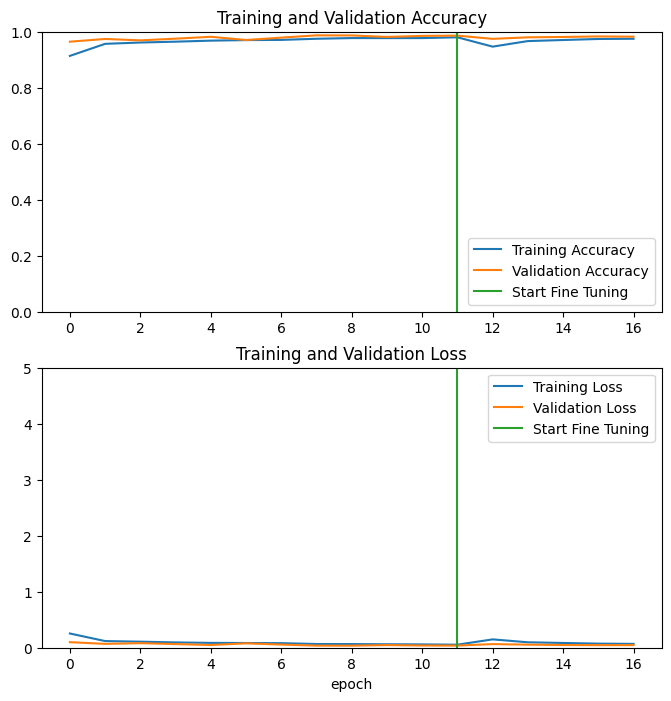

In [8]:
def plot_history(history, history_fine, initial_epochs=12):
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    plt.figure(figsize=(8, 8))
    
    # Plot Accuracy
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0, 1])
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 5.0])
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Run the plot
plot_history(history, history_fine)

Generating predictions for Confusion Matrix...


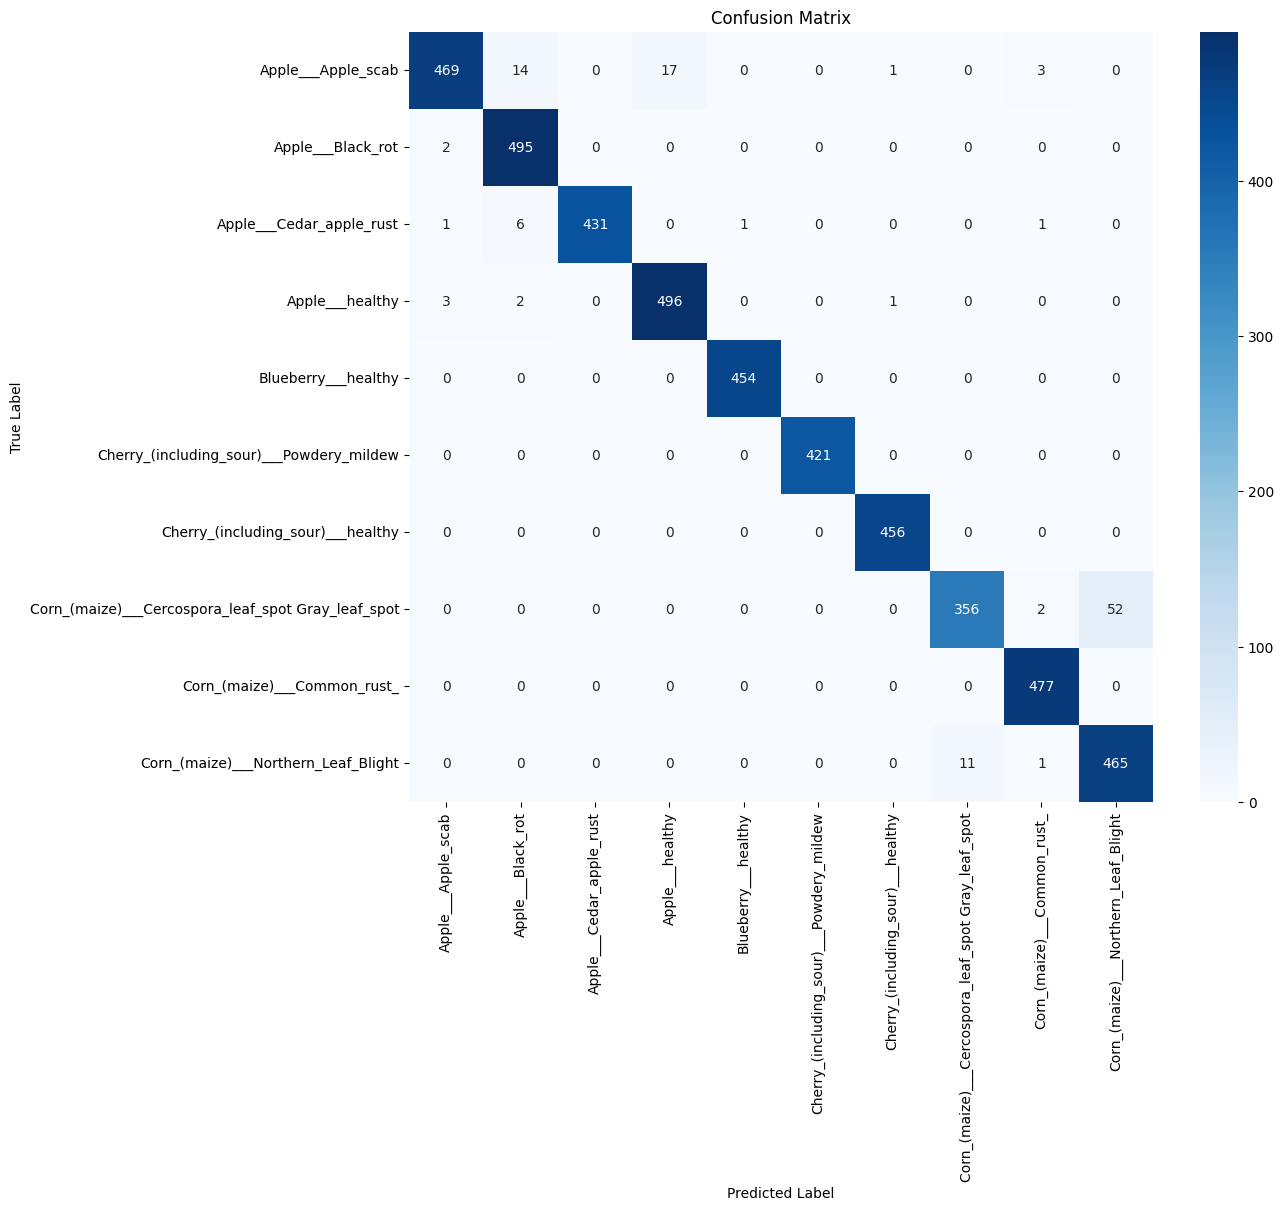


Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.93      0.96       504
                                 Apple___Black_rot       0.96      1.00      0.98       497
                          Apple___Cedar_apple_rust       1.00      0.98      0.99       440
                                   Apple___healthy       0.97      0.99      0.98       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.87      0.92       410
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       477
               Corn_(maize)___Northern_Leaf_Blight    

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions and True Labels from Validation Set
y_true = []
y_pred = []

print("Generating predictions for Confusion Matrix...")

# Iterate through the validation dataset
for images, labels in val_ds:
    # Get model predictions
    preds = model.predict(images, verbose=0)
    # Convert probabilities to class index
    pred_labels = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

# 4. Print Detailed Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

C:\Users\AjinkyaBahirat\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


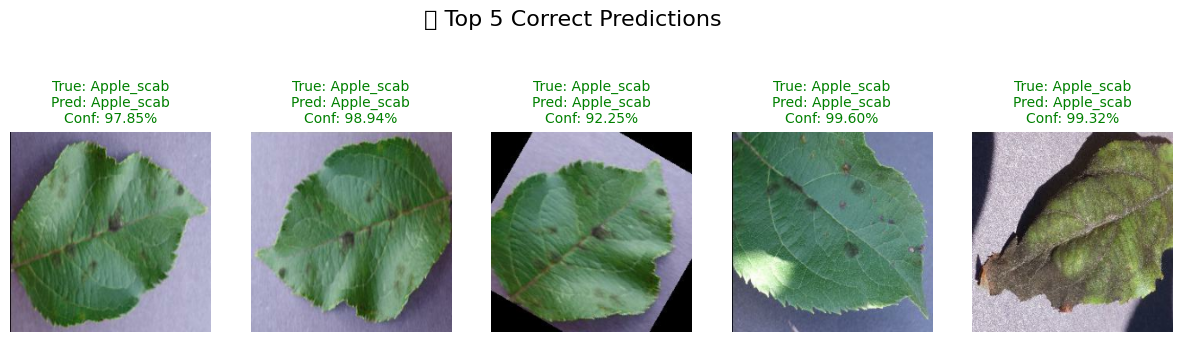

C:\Users\AjinkyaBahirat\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


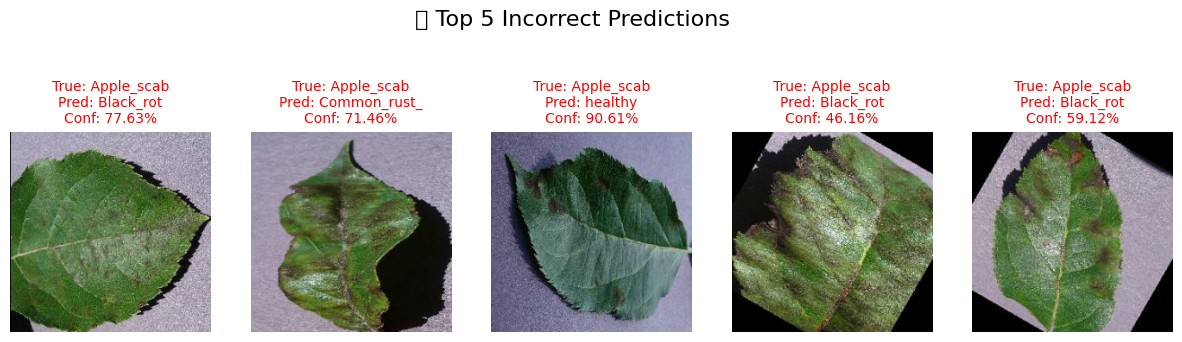

In [11]:
def visualize_predictions(dataset, model, class_names, num_examples=5):
    correct_images = []
    incorrect_images = []
    
    # Iterate through batches until we find enough examples
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        pred_idxs = np.argmax(preds, axis=1)
        
        for i in range(len(images)):
            true_label = class_names[labels[i]]
            pred_label = class_names[pred_idxs[i]]
            confidence = np.max(preds[i])
            
            # Convert image for display (0-255 range)
            img_display = images[i].numpy().astype("uint8")
            
            # Store Correct Predictions
            if true_label == pred_label and len(correct_images) < num_examples:
                correct_images.append((img_display, true_label, pred_label, confidence))
                
            # Store Incorrect Predictions
            elif true_label != pred_label and len(incorrect_images) < num_examples:
                incorrect_images.append((img_display, true_label, pred_label, confidence))
        
        # Stop if we have enough of both
        if len(correct_images) >= num_examples and len(incorrect_images) >= num_examples:
            break

    # --- Plotting Function ---
    def plot_grid(data_list, title_text):
        plt.figure(figsize=(15, 4))
        plt.suptitle(title_text, fontsize=16, y=1.05)
        for idx, (img, true, pred, conf) in enumerate(data_list):
            plt.subplot(1, num_examples, idx + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Color title green for correct, red for incorrect
            color = 'green' if true == pred else 'red'
            
            plt.title(f"True: {true.split('___')[-1]}\nPred: {pred.split('___')[-1]}\nConf: {conf:.2%}", 
                      color=color, fontsize=10)
        plt.show()

    plot_grid(correct_images, "✅ Top 5 Correct Predictions")
    plot_grid(incorrect_images, "❌ Top 5 Incorrect Predictions")

# Run the visualization
visualize_predictions(val_ds, model, classes)